In [1]:
#JV

I am taking the following Approach:

1. I am trying to build each of the specified functionality in this notebook
2. Upon wirting correct code for a functionality, I would add it to the final python file, in the same dir

So, the efforts and the incremental progress can be seen by checking the versions of this notebook (.ipynb)
and the best version of the functionalities (for different questions) would incrementally be added to the .py file

In [2]:
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
#from tqdm import tqdm_gui,tqdm
from tqdm.notebook import tqdm
import gc
import time

#### Question 1 : MNIST import and Plot Classes

In [3]:
## Importing the data

"""unpacking data returned by load_data(), as specified in keras docs"""
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()

""" Merging the data to perform a random train-test split """
X = np.concatenate((x_train,x_test))
Y = np.concatenate((y_train,y_test))

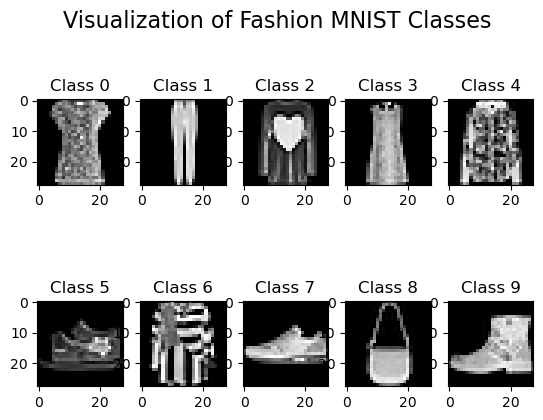

In [4]:
#Plotting 1 image per class

""" For each class, identify an index at which the correspondingimage can be found"""
classwise_indices_of_image_in_data = [np.where(Y==i)[0][-1] for i in range(10)]

""" plotting """
fig = plt.figure()

fig.suptitle("Visualization of Fashion MNIST Classes", fontsize=16)

rows_in_plot = 2
cols_in_plot = 5

for i in range(10):
    
    ax = plt.subplot(rows_in_plot, cols_in_plot, i+1)
    ax.set_title("Class "+str(i))
    ax.imshow(X[classwise_indices_of_image_in_data[i]],cmap=plt.get_cmap('gray'))



#### Question 2 : Create Neural Network and Implement Forward Pass

In [89]:
class Initializer:
    """
    Class containing methods to initialize parameters of neural network.
    """

    def __init__(self,seed=2):
        """
        Default constructor

        params:

            seed : Default seed, for an instance of this class, used for initialization.
        
        """

        self.random_num_generator = np.random.RandomState(seed)
        

    def random(self,shape,distribution="normal",param1=0,param2=0.2):
        """
        Method to perform random initialization.

        params:

            shape: The shape of the numpy array that has to be initialized.
            distribution : "normal" or "uniform"; default is "normal".
            param1 : mean of normal or lower limit of random uniform.
            param2 : stddev of normal or upper limit of random normal.

        Returns:

            a numpy array of the given shape after random (uniform/normal) initialization.
        """

        if distribution == "normal":

            return self.random_num_generator.normal(param1,param2,size=shape)


        elif distribution == "uniform":

            return self.random_num_generator.uniform(param1,param2,size=shape)


    def xavier(self,shape,distribution="normal",fanIn=1,fanOut=1,isBiases=False):

        """
        
        Method to initialize parameters of a neural network, according to xavier initialization.
        
        params:

            shape: The shape of the numpy array that has to be initialized.
            distribution : "normal" or "uniform"; default is "normal".
            fanIn : Number of neurons in the previous layer. Default is 1.
            fanOut : Number of neurons in the next layer. Default is 1.
            isBiases : As per the original paper on xavier initialization, biases are initialzied to zero. Following the same.

        Returns:

            a numpy array of the given shape after xavier(uniform/normal) initialization.
        
        """

        if isBiases:

            return np.zeros((shape))

        if distribution == "normal":

            mu = 0
            sigma = np.sqrt(2/(fanIn+fanOut))

            return self.random_num_generator.normal(mu,sigma,size=shape)

        elif distribution == "uniform":

            bound = np.sqrt(6/(fanIn+fanOut))

            return self.random_num_generator.uniform(-bound,bound,size=shape)
    
            

In [6]:
class Activation:

    """
    A class containing methods of activation functions to be applied to the layers of the Neural Network.

    Currently supported Activations : sigmoid, tanh and ReLu

    More activation functions can be added as required by adding a method.
    """

    def __init__(self):
        """
        Default Constructor
        """
        pass

    def sigmoid(self,x):
        """
        A method to immplement logistic version of sigmoid activation function.

        Params:
            x : numpy array

        Returns:
            Array after applying sigmoid
        """

        return 1/(1+np.exp(-x))

    
    def tanh(self,x):
        """
        A method to immplement tanh activation.

        Params:
            x : numpy array

        Returns:
            Array after applying tanh
        """

        
        return np.tanh(x)


    def relu(self,x):
        """
        A method to immplement ReLu activation.

        Params:
            x : numpy array

        Returns:
            Array after applying ReLu        
        """

        return np.maximum(x,0)

    def identity(self,x):

        """
        A method to immplement identity activation.

        Params:
            x : numpy array

        Returns:
            Input as is.        
        """
        
        return x

    def softmax(Self,x):
        """
        A method that returns the softmax of the input vector.

        Mostly meant for the activation of the output layer.

        params:
            x: numpy array

        returns:
            softmax transformed input.
        
        """

        return np.exp(x)/np.sum(np.exp(x))

In [7]:
def grad_activation(activation="relu"):

    """
    Method to return a method which evaluates the gradient of the activation used at a point x in the space.

    To avoid the use of autograd/diff packages, the closed form of the derivatives is computed before hand and plugged in here.

    Such an approach is taken to build and train a neural network from scratch, instead of depending on existing libraries.

    This new activation functions can easily be added by creating a method that evaluates the closed form of the derivative at any given point x.
    and an appropriate elif condition must be added.

    params:

        activation : currently supported : "relu" [Default] ,"tanh",sigmoid".

    returns:

        An invokable method that produces deriviative of the activation function evaluated at x.
    
    """

    def grad_relu(x):

        x[x<=0] = 0
        x[x>0] = 1

        return x

    def grad_tanh(x):

        return 1-(np.tanh(x))**2

    def grad_sigmoid(x):

        logistic =  1/(1+np.exp(-x))

        return logistic*(1-logistic)

    if activation=="relu":
        return grad_relu

    elif activation=="tanh":
        return grad_tanh

    elif activation=="sigmoid":
        return grad_sigmoid
    

In [15]:
class NeuralNetwork:
    """
        A class containing methods to create a neural network, perform forward pass (prediction) and backpropogation/training
    """
    def __init__(self,seed=36):
        
        self.seed = seed


    def createNNet(self,input_neurons=784,output_neurons=10,number_of_hidden_layers=3,neurons_per_hidden_layer=[32]*3,initialization = "random",activation="sigmoid",output_activation = "softmax"):

        """
        Method to create a neural network, with specified number of inputs, outputs, hidden layers and neurons per hidden layer,

        with specified activation, output.

        With the weights and biases initialized as per the specified initialization strategy

        Params:

            input_neurons (default=784): Number of input features.
            
            output_neurons (default=10): Number of outputs.
            
            number_of_hidden_layers (default=3): Number of hidden layers.
            
            neurons_per_hidden_layer (default=[32]*3): List of number of neurons per hidden layer.
            
            initialization (default="random"): Parameter initialization process : "random normal" or "xavier normal"
            
            activation (default="sigmoid"): Activation function for all the hidden layers ("sigmoid","relu","tanh","identity")
            
            output_activation (default="softmax"): Activation function for the output layer ("softmax","linear")

        Returns:

            None.
        
        """


        ## setup the variables governing the network's architecture
        
        self.input_neurons = input_neurons
        self.output_neurons = output_neurons
        
        self.number_of_hidden_layers = number_of_hidden_layers
        self.neurons_per_hidden_layer = neurons_per_hidden_layer
        self.neurons_per_layer = [input_neurons] + self.neurons_per_hidden_layer + [output_neurons]


        ## Compute the shape of biases and weights in the direction of input to output
        
        self.weight_shapes = [(self.neurons_per_layer[i+1],self.neurons_per_layer[i]) for i in range(len(self.neurons_per_layer)-1)]
        self.bias_shapes = self.neurons_per_layer[1:]
        

        ## setup and get a handle on the initializer
        
        init_obj = Initializer(seed=self.seed)

        if initialization == "random":

            self.intializer = init_obj.random

        elif initialization == "xavier":

            self.intializer = init_obj.xavier


        ## Weights and biases are stored as list of numpy arrays
        ## They are orgnaized from the first hidden layer (closest to input) to the last hidden layer.
        
        
        self.weights = []
        self.biases = []
        
        for i in range(self.number_of_hidden_layers+1):

            if initialization == "random":
            
                self.weights.append(self.intializer(self.weight_shapes[i]))
                self.biases.append(self.intializer(self.bias_shapes[i]))
            

            if initialization == "xavier":

                pass

                """ Need to figure out fanIn and fanOut computation """

                fanIn = self.weight_shapes[-1-i][1]
                fanOut = self.weight_shapes[-1-i-1][0]

                self.weights.append(self.intializer(self.weight_shapes[i],fanIn,fanOut))
                self.biases.append(self.intializer(self.bias_shapes[i],isBiases=True))




        activation_obj = Activation()
                
        if activation == "sigmoid":
                
            self.activation = activation_obj.sigmoid
            
        elif activation == "tanh":
                
            self.activation = activation_obj.tanh

        elif activation == "relu":
                
            self.activation = activation_obj.relu

        elif activation == "identity":

            self.activation = activation_obj.identity

        output_obj = Activation()

        if output_activation == "softmax":

            self.output_activation = output_obj.softmax


    def forward(self,x):

        """
        Method to perform the forward pass on the neural network and return the outputs.

        params:

            x : Numpy array, the input vector.

        Returns : 

            output numpy array as the result of forward propagation of the input through the network.
        
        """

        a = [] ## list of layer wise pre-activation outputs
        h = [x] ## h0 is input. This is list of post activation outputs, except final output
         
        
        cur_out = x
        
        for i in range(self.number_of_hidden_layers+1):

            ai = self.weights[i]@cur_out+self.biases[i] ## compute pre activation output ith layer
            
            if i == self.number_of_hidden_layers:
                
                output = self.output_activation(ai)

            else:
                cur_out = self.activation(ai) ## post activation output of the ith (non-output) layer
                h.append(cur_out)

            a.append(ai)
                
        return a,h,output

    def backprop(self,a,h,y_true,y_pred,activation):

        """
        Method to perform the backpropagation in the network to compute and return the gradients w.r.t the parameters.

        Params:
            a : List of pre-activation values collected during forward pass.
            h : List of post-activation values for hidden layers collected during forward pass.
            y_true : One hot encoding of the true input label for a specific input.
            y_pred : The predicted class distribution for the same input.
            activation : the activation function of hidden layers. It helps us to evaluate the derivative based on the activation.

        Returns:

            The list of layer wise gradients.
        
        """

        activation_grad = grad_activation(activation)

        dw_list = [] ## list of gradients of weights from last layer to 1st layer

        db_list = [] ## list of gradients of biases from last layer to 1st layer
        
        grad_aL = -(y_true-y_pred)  ## gradient of loss w.r.t pre-activation of output layer

        grad_ai = grad_aL

        for i in range(self.number_of_hidden_layers,-1,-1):

            
            grad_Wi = np.outer(grad_ai,h[i]) ## gradient of loss w.r.t weights of ith layer. it's h[i] as per the algo, but to adjust indexing to access the right element, h[i] is used

            dw_list.append(grad_Wi)
            
            grad_bi = grad_ai ## gradient of loss w.r.t biases of ith layer.
            db_list.append(grad_bi)

            if(i>0): ## i.e only if a layer is present before the current layer

                grad_h_prev = self.weights[i].T @ grad_ai ## gradient of loss w.r.t activation of previous layer
    
                grad_a_prev = grad_h_prev * activation_grad(a[i-1]) ##gradient of loss wrt pre-activation of previous layer
    
                grad_ai = grad_a_prev

        return dw_list, db_list


In [67]:
class Optimiser:

    """
    A class containing methods of optimizers including

        Stochastic Gradient Descent (sgd)
        Gradient Desecent with Momentum (gd_momentum)
        Nesterov accelerated Gradient Descent (nesterov_gd)
        rmsprop (rmsprop)
        adam (adam)
        nadam (nadam)
    """

    def compute_accuracy(self,nn,data):

        x_data,y_data = data

        list_of_predicted_classes = []
    
        for i in range(x_data.shape[0]):
    
            _,_,prediction_probs = nn.forward(x_data[i])
            list_of_predicted_classes.append(np.argmax(prediction_probs))

    
        unique,counts = np.unique(np.array(list_of_predicted_classes) == y_data, return_counts=True)
    
        accuracy = dict(zip(unique, counts))[True]/y_data.shape[0]
        
        #print("Accuracy : "+str(round(accuracy*100,2))+"%")

        return round(accuracy*100,2)
    

    def sgd(self,nn,train_data,val_data,lr=1e-3,epochs=5,batch_size=1,l2_param=0,print_val_accuracy=True):

        """
        Method performs the stochastic gradient descent with default batch size as 1; increasing batch size makes it mini batch gradient descent.
        
        params:

            nn : An object corresponding to an initalized or ready neural network

            lr : learning rate parameter (default  :1e-3)

            epochs : number of training epochs (default : 5)

            batch size : mini batch size, default is 1

            l2_param : l2_regularization coefficient, default is 0.

        returns:

            None.
        
        """

        x_train = train_data[0]
        y_train = train_data[1]

        print(y_train.shape)

        for epoch in tqdm(range(epochs)):

            dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            points_seen = 0
            
            for i in tqdm(range(y_train.shape[0])):


                #create a one hot encoding of the true label
                y_true = np.zeros(nn.output_neurons)
                y_true[y_train[i]] = 1

                a,h,y_pred_probs = nn.forward(x_train[i].flatten()/255) ## apply forward pass on input
                
                dw_cur,db_cur = nn.backprop(a,h,y_true,y_pred_probs,activation) ## backprop now
                

                dw_cur.reverse() ##dw returned by backprop are from last layer to first layer weights, hence reversing
                db_cur.reverse() ##db returned by backprop are from last layer to first layer weights, hence reversing
                
                ## accumulate gradients of Weights and Biases.
                dw = list(np.array(dw,dtype=object) + np.array(dw_cur,dtype=object))
                
                db = list(np.array(db,dtype=object) + np.array(db_cur,dtype=object))
                
                points_seen += 1

                if(points_seen%batch_size == 0): ## seen mini batch number of points so update the parameters now


                    nn.weights = list(np.array(nn.weights,dtype = object) - lr*(1+l2_param)*np.array(dw,dtype=object))
                    nn.biases = list(np.array(nn.biases,dtype = object) - lr*(1+l2_param)*np.array(db,dtype=object))

                    #reset the grads of weights and biases
                    dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
                    db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
                    
            if print_val_accuracy: ##if true, prints validation accuracy after the current epoch.
            
                val_accuracy = self.compute_accuracy(nn,val_data)
                training_accuracy = self.compute_accuracy(nn,train_data)

                print(f"Training Accuracy : {training_accuracy}%  Validation Accuracy : {val_accuracy}%")


    def gd_momentum(self,nn,train_data,val_data,lr=1e-3,epochs=5,batch_size=1,l2_param=0,print_val_accuracy=True,momentum=0.9):

        """
        Method performs the stochastic gradient descent with default batch size as 1; increasing batch size makes it mini batch gradient descent.
        
        params:

            nn : An object corresponding to an initalized or ready neural network

            lr : learning rate parameter (default  :1e-3)

            epochs : number of training epochs (default : 5)

            batch size : mini batch size, default is 1

            l2_param : l2_regularization coefficient, default is 0.

            momentum : The momentum parameter. Default is 0.9

        returns:

            None.
        
        """

        x_train = train_data[0]
        y_train = train_data[1]

        print(y_train.shape)

        for epoch in tqdm(range(epochs)):

            dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]

            prev_uw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            prev_ub = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
            
            points_seen = 0
            
            for i in tqdm(range(y_train.shape[0])):


                #create a one hot encoding of the true label
                y_true = np.zeros(nn.output_neurons)
                y_true[y_train[i]] = 1

                a,h,y_pred_probs = nn.forward(x_train[i].flatten()/255) ## apply forward pass on input
                
                dw_cur,db_cur = nn.backprop(a,h,y_true,y_pred_probs,activation) ## backprop now
                

                dw_cur.reverse() ##dw returned by backprop are from last layer to first layer weights, hence reversing
                db_cur.reverse() ##db returned by backprop are from last layer to first layer weights, hence reversing
                
                ## accumulate gradients of Weights and Biases.
                dw = list(np.array(dw,dtype=object) + np.array(dw_cur,dtype=object))
                
                db = list(np.array(db,dtype=object) + np.array(db_cur,dtype=object))
                
                points_seen += 1

                if(points_seen%batch_size == 0): ## seen mini batch number of points so update the parameters now

                    uw = momentum*np.array(prev_uw,dtype=object) + lr*np.array(dw,dtype=object)
                    ub = momentum*np.array(prev_ub,dtype=object) + lr*np.array(db,dtype=object)
                    
                    nn.weights = list(np.array(nn.weights,dtype = object) - uw  - lr*l2_param*np.array(dw,dtype=object))
                    nn.biases = list(np.array(nn.biases,dtype = object) - ub - lr*l2_param*np.array(db,dtype=object))

                    #reset the grads of weights and biases
                    dw = [np.zeros(nn.weight_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]
                    db = [np.zeros(nn.bias_shapes[i]) for i in range(nn.number_of_hidden_layers+1)]

                    prev_uw = uw
                    prev_ub = ub
                    
            if print_val_accuracy: ##if true, prints validation accuracy after the current epoch.
            
                val_accuracy = self.compute_accuracy(nn,val_data)
                training_accuracy = self.compute_accuracy(nn,train_data)

                print(f"Training Accuracy : {training_accuracy}%  Validation Accuracy : {val_accuracy}%")
                        

#### Train Validation (90-10) split

In [100]:
## train-test data is got from the mnist fashion import data call
## now this data is being flattened, i.e each image into a 1d array
## then flattened train data is split into 80% train and 20% validation data.


seed = 76 #setting 36 as seed wherever randomness comes

x_train_flattened = x_train.flatten().reshape(x_train.shape[0],-1)
x_test_flattened = x_test.flatten().reshape(x_test.shape[0],-1)


#np.random.seed(seed)
random_num_generator = np.random.RandomState(seed)


validation_indices = random_num_generator.choice(x_train_flattened.shape[0],int(0.1*x_train_flattened.shape[0]),replace=False)
train_indices = np.array(list(set(np.arange(x_train_flattened.shape[0])).difference(set(validation_indices))))

x_train_data = x_train_flattened[train_indices]
y_train_data = y_train[train_indices]

x_validation_data = x_train_flattened[validation_indices]
y_validation_data = y_train[validation_indices]


### Create a NNet and Train it using SGD

In [104]:


nn = NeuralNetwork(seed=seed)

activation = "tanh"

#nn.createNNet(activation=activation)

#nn.createNNet(input_neurons=784,output_neurons=10,number_of_hidden_layers=3,neurons_per_hidden_layer=[32]*3,initialization = "random",activation="sigmoid",output_activation = "softmax")

nn.createNNet(number_of_hidden_layers=3,neurons_per_hidden_layer=[64]*3,initialization = "random",activation=activation)

In [105]:
optim = Optimiser()

#l2 : 0.0005
optim.gd_momentum(nn,[x_train_data,y_train_data],[x_validation_data,y_validation_data],lr=1e-3,epochs=14,batch_size=16,l2_param=0.0005,print_val_accuracy=True)

(54000,)


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 81.43%  Validation Accuracy : 81.08%


  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 83.72%  Validation Accuracy : 83.15%


  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 83.05%  Validation Accuracy : 81.83%


  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 84.28%  Validation Accuracy : 83.03%


  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 84.28%  Validation Accuracy : 83.07%


  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 84.63%  Validation Accuracy : 83.47%


  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 84.62%  Validation Accuracy : 83.12%


  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 85.51%  Validation Accuracy : 84.0%


  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 84.97%  Validation Accuracy : 83.67%


  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 85.8%  Validation Accuracy : 84.17%


  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 86.04%  Validation Accuracy : 84.3%


  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 85.8%  Validation Accuracy : 84.23%


  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 85.38%  Validation Accuracy : 83.9%


  0%|          | 0/54000 [00:00<?, ?it/s]

Training Accuracy : 86.58%  Validation Accuracy : 85.2%


In [106]:
### Compute Test Accuracy

test_accuracy = Optimiser().compute_accuracy(nn,[x_test_flattened,y_test])
print(f"Test Accuracy : {test_accuracy}%")

Test Accuracy : 83.95%


##### To do:

1. ~~Doc string for createNNet~~

2. ~~data Preprocessing:~~
    * ~~validation data split~~
    * ~~data flattening~~
    * ~~data normalization by 255~~ *Data normalization is found to be limiting the maximum attainable validation accuracy.*

3. ~~implement backprop and accordingly adjust the forward method~~

4. ~~Optimizers as a different class, with parameters like learning rate passed directly to the methods. The neural network object must be passed to the optimizer method~~

5. ~~SGD~~, ~~momentum~~,nesterov, rmsprop, adam, nadam

7. Finish implementaion of Xavier initialization.


#### Important Considerations:

1. To avoid the use of autograd/diff packages, the closed form of the derivatives is computed before hand and plugged as and when required here.

2. All hidden layers are a fully connected layer, i.e there is a weight from each neuron in the present layer to every neuron in the next layer.

3. It is assumed that all the hidden layers use the same activation function.

4. The backprop code is based on the algorithm in https://iitm-pod.slides.com/arunprakash_ai/cs6910-lecture-4/fullscreen#/0/70/8

5. It assumes that the loss used is cross entropy loss and the output activation is softmax. These assumptions are to avoid the need to depend on autograd packages, as the closed form of the derivatives in the chain rule could be now directly computed


### References:

1. http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf [xavier initializatization]
2. 